In [5]:
import numpy as np
import xgboost as xgb

In [8]:
dtrain = xgb.DMatrix('agaricus.txt.train')
dtest = xgb.DMatrix('agaricus.txt.test')

print("Train dataset contains {0} rows and {1} columns".format(dtrain.num_row(), dtrain.num_col()))
print("Test dataset contains {0} rows and {1} columns".format(dtest.num_row(), dtest.num_col()))

print("Train possible labels: ")
print(np.unique(dtrain.get_label()))

print("\nTest possible labels: ")
print(np.unique(dtest.get_label()))

[21:47:01] 6513x127 matrix with 143286 entries loaded from agaricus.txt.train
[21:47:01] 1611x127 matrix with 35442 entries loaded from agaricus.txt.test
Train dataset contains 6513 rows and 127 columns
Test dataset contains 1611 rows and 127 columns
Train possible labels: 
[0. 1.]

Test possible labels: 
[0. 1.]


### Train the model <a name='params' />

Specify training parameters

In [8]:
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':0.5
}

num_rounds = 5

### Training classifier<a name='train' />

In [14]:
# see how does it perform
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.042831	train-error:0.046522
[1]	test-error:0.021726	train-error:0.022263
[2]	test-error:0.006207	train-error:0.007063
[3]	test-error:0.018001	train-error:0.0152
[4]	test-error:0.006207	train-error:0.007063


### Make predictions<a name='predict' />

In [17]:
preds_prob = bst.predict(dtest)
preds_prob

array([0.08073306, 0.92217326, 0.08073306, ..., 0.98059034, 0.01182149,
       0.98059034], dtype=float32)

In [18]:
# Calculate simple accuracy metric to verify the results.
labels = dtest.get_label()
preds = preds_prob > 0.5 # threshold
correct = 0

for i in range(len(preds)):
    if (labels[i] == preds[i]):
        correct += 1

print('Predicted correctly: {0}/{1}'.format(correct, len(preds)))
print('Error: {0:.4f}'.format(1-correct/len(preds)))

Predicted correctly: 1601/1611
Error: 0.0062


### Representation of a tree<a name='tree' />

In [19]:
trees_dump = bst.get_dump(fmap='data/featmap.txt', with_stats=True)

for tree in trees_dump:
    print(tree)

0:[odor=pungent] yes=2,no=1,gain=4000.53101,cover=1628.25
	1:[stalk-root=cup] yes=4,no=3,gain=1158.21204,cover=924.5
		3:leaf=1.71217716,cover=812
		4:leaf=-1.70044053,cover=112.5
	2:[spore-print-color=orange] yes=6,no=5,gain=198.173828,cover=703.75
		5:leaf=-1.94070864,cover=690.5
		6:leaf=1.85964918,cover=13.25

0:[stalk-root=missing] yes=2,no=1,gain=832.545044,cover=788.852051
	1:[odor=pungent] yes=4,no=3,gain=569.725098,cover=768.389709
		3:leaf=0.78471756,cover=458.936859
		4:leaf=-0.968530357,cover=309.45282
	2:leaf=-6.23624468,cover=20.462389

0:[ring-type=sheathing] yes=2,no=1,gain=368.744568,cover=457.069458
	1:[stalk-surface-below-ring=silky] yes=4,no=3,gain=226.33696,cover=221.051468
		3:leaf=0.658725023,cover=212.999451
		4:leaf=5.77228642,cover=8.05200672
	2:[spore-print-color=white] yes=6,no=5,gain=258.184265,cover=236.018005
		5:leaf=-0.791407049,cover=233.487625
		6:leaf=-9.421422,cover=2.53038669

0:[odor=musty] yes=2,no=1,gain=140.486069,cover=364.119354
	1:[gill-size

### Plotting<a name='plot' />


Bad key "text.kerning_factor" on line 4 in
C:\Users\Etudiant\.conda\envs\pytorch_p37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


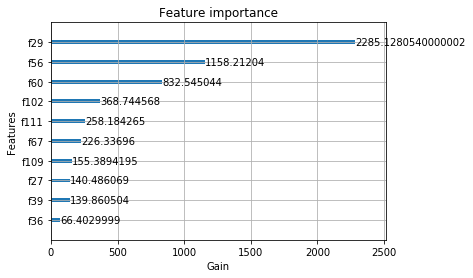

In [20]:
xgb.plot_importance(bst, importance_type='gain', xlabel='Gain')

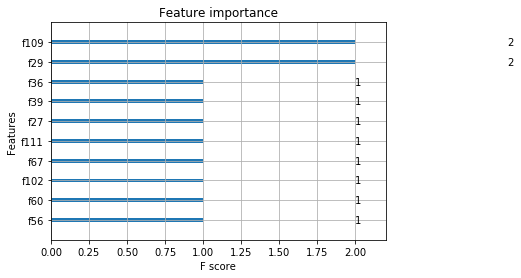

In [22]:
# F-score
xgb.plot_importance(bst)

In [23]:
importances = bst.get_fscore()
importances

{'f29': 2,
 'f56': 1,
 'f109': 2,
 'f60': 1,
 'f102': 1,
 'f67': 1,
 'f111': 1,
 'f27': 1,
 'f39': 1,
 'f36': 1}

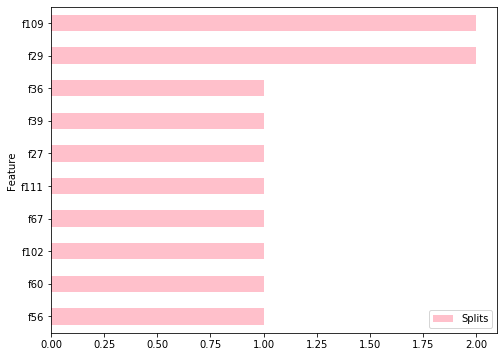

In [26]:
# create df
import pandas as pd
importance_df = pd.DataFrame({
        'Splits': list(importances.values()),
        'Feature': list(importances.keys())
    })
importance_df.sort_values(by='Splits', inplace=True)
importance_df.plot(kind='barh', x='Feature', figsize=(8,6), color='pink')

# Bias/variance 


In [67]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_svmlight_files
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack
from scipy.stats import randint, uniform

# reproducibility
seed = 123
np.random.seed(seed)

In [52]:
# generate artificial dataset
X = 'data/agaricus.txt.train'
y = 'data/agaricus.txt.test'
X, y = make_classification(n_samples=1000, n_features=20, n_informative=8, n_redundant=3, n_repeated=2, random_state=seed)

In [60]:
# divide into 10 stratified folds (the same distibution of labels in each fold) for testing
#cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=seed)
cv = StratifiedKFold( n_splits=10, shuffle=True, random_state=seed)

In [61]:
# check how the number of trees influence the predictions accuracy
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'silent': 1
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)

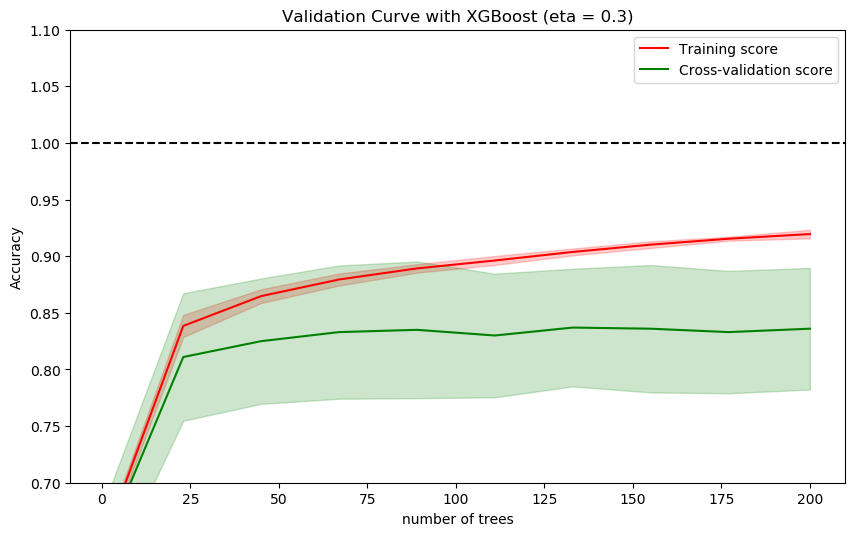

Best cross-validation result (0.84) obtained for 133 trees


In [62]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

In [63]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 2, # changed
    'learning_rate': 0.3,
    'silent': 1,
    'colsample_bytree': 0.6, # added
    'subsample': 0.7 # added
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)

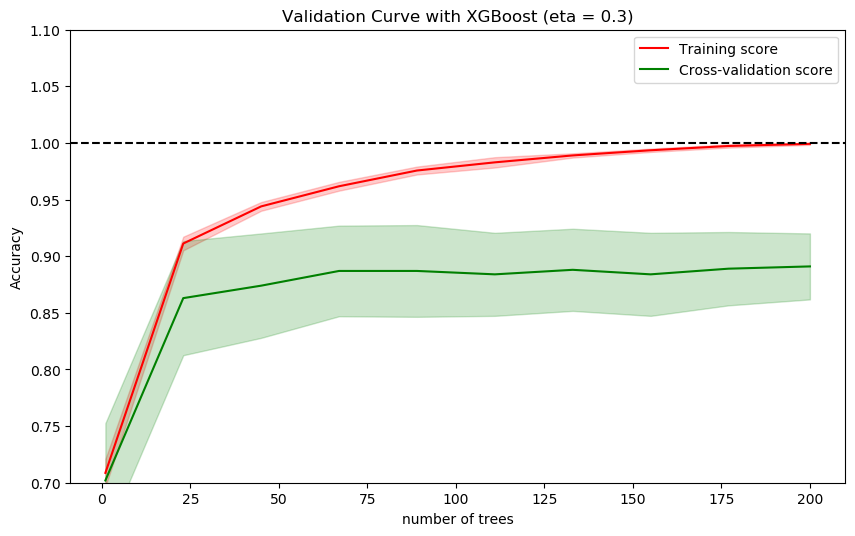

Best cross-validation result (0.89) obtained for 200 trees


In [64]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

In [68]:
# Defining parameters for grid_search
params_grid = {
    'max_depth': [1, 2, 3],
    'n_estimators': [5, 10, 25, 50],
    'learning_rate': np.linspace(1e-16, 1, 3)
}

# add a dictionary for fixed parameters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

# Create a GridSearchCV estimator.
bst_grid = GridSearchCV(
    estimator=XGBClassifier(**params_fixed, seed=seed),
    param_grid=params_grid,
    cv=cv,
    scoring='accuracy'
)
bst_grid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=123, silent=1,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': array([1.e-16, 5.e-01, 1.e+00]),
                         'max_dept

In [76]:
#  the largeer n_estimators, the accuracy is higher.
bst_grid.cv_results_

{'mean_fit_time': array([0.00449927, 0.00680044, 0.01370604, 0.02529933, 0.00590429,
        0.00979798, 0.02160132, 0.04159606, 0.0079016 , 0.01390243,
        0.03230548, 0.06239982, 0.0041008 , 0.00619986, 0.01320095,
        0.02490461, 0.00599802, 0.01029601, 0.02319942, 0.04260559,
        0.00849767, 0.01440427, 0.03169203, 0.05939925, 0.00419972,
        0.00619454, 0.0130003 , 0.02399671, 0.00589933, 0.00959921,
        0.02210295, 0.04100344, 0.00769999, 0.01349831, 0.03119862,
        0.05660281]),
 'std_fit_time': array([8.06983195e-04, 1.16863774e-03, 8.95169104e-04, 2.28354430e-03,
        3.04722322e-04, 6.02086752e-04, 4.88479259e-04, 6.56637804e-04,
        5.32268269e-04, 2.88156624e-04, 1.26644467e-03, 6.64889453e-04,
        2.99362055e-04, 4.00242756e-04, 3.97713003e-04, 1.22059013e-03,
        2.17053242e-05, 8.96567671e-04, 1.40659891e-03, 1.44057653e-03,
        6.76259611e-04, 6.71478883e-04, 1.00076777e-03, 1.02323701e-03,
        4.02900981e-04, 4.08816676e-0

In [77]:
print("Best accuracy obtained: {0}".format(bst_grid.best_score_))
print("Parameters:")
for key, value in bst_grid.best_params_.items():
    print("\t{}: {}".format(key, value))

Best accuracy obtained: 0.9
Parameters:
	learning_rate: 0.5
	max_depth: 3
	n_estimators: 50


### Randomized Grid-Search<a name='rgrid' />

In [78]:
# Create a parameters distribution dictionary:
params_dist_grid = {
    'max_depth': [1, 2, 3, 4],
    'gamma': [0, 0.5, 1],
    'n_estimators': randint(1, 1001), # uniform discrete random distribution
    'learning_rate': uniform(), # gaussian distribution
    'subsample': uniform(), # gaussian distribution
    'colsample_bytree': uniform() # gaussian distribution
}

In [79]:
rs_grid = RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed, seed=seed),
    param_distributions=params_dist_grid,
    n_iter=10,
    cv=cv,
    scoring='accuracy',
    random_state=seed
)

In [80]:
#Fit the classifier:
rs_grid.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='bi...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000212073D58C8>,
                                        'max_depth': [1, 2, 3, 4],
                                        'n_est

In [82]:
rs_grid.cv_results_

{'mean_fit_time': array([0.62740214, 0.04001591, 0.13329654, 0.21680291, 0.09299185,
        0.11390402, 0.06380067, 0.04379594, 0.18329577, 0.12789807]),
 'std_fit_time': array([0.01708375, 0.00140078, 0.00394923, 0.00754065, 0.0019084 ,
        0.00144171, 0.0006015 , 0.00039705, 0.0006395 , 0.00094316]),
 'mean_score_time': array([0.00100226, 0.00048921, 0.00099995, 0.00140052, 0.00090663,
        0.00079994, 0.00059991, 0.00100021, 0.00100319, 0.00090175]),
 'std_score_time': array([2.98128110e-06, 4.89309958e-04, 1.62301423e-05, 4.89892815e-04,
        3.02876289e-04, 3.99972472e-04, 4.89826451e-04, 1.66483786e-06,
        9.28795677e-06, 3.00589589e-04]),
 'param_colsample_bytree': masked_array(data=[0.6964691855978616, 0.49111893343259727,
                    0.3921175181941505, 0.694755177185269,
                    0.5315513738418384, 0.740296390734788,
                    0.22826323087895561, 0.02798195504294898,
                    0.4263513069628082, 0.5684306928188979],
  

In [83]:
# analyze best estimator, parameters and obtained score:
rs_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6964691855978616, gamma=1,
              learning_rate=0.4284709261868257, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=743, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123, silent=1,
              subsample=0.719150310154773, verbosity=1)

In [84]:
rs_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6964691855978616, gamma=1,
              learning_rate=0.4284709261868257, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=743, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123, silent=1,
              subsample=0.719150310154773, verbosity=1)

In [85]:
rs_grid.best_score_

0.891

# Evaluate results

In [86]:
from pprint import pprint

In [87]:
# specify general training parameters
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':0.5
}

num_rounds = 5



In [88]:
watchlist  = [(dtest,'test'), (dtrain,'train')]

In [89]:
bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.11049	train-error:0.113926
[1]	test-error:0.11049	train-error:0.113926
[2]	test-error:0.03352	train-error:0.030401
[3]	test-error:0.027312	train-error:0.021495
[4]	test-error:0.031037	train-error:0.025487


In [90]:
params['eval_metric'] = 'logloss'
bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-logloss:0.457893	train-logloss:0.460117
[1]	test-logloss:0.383914	train-logloss:0.378727
[2]	test-logloss:0.312679	train-logloss:0.308074
[3]	test-logloss:0.269116	train-logloss:0.261396
[4]	test-logloss:0.239746	train-logloss:0.232171


### Creating custom evaluation metric<a name='cmetrics' />

In [91]:
# custom evaluation metric
def misclassified(pred_probs, dtrain):
    labels = dtrain.get_label() # obtain true labels
    preds = pred_probs > 0.5 # obtain predicted values
    return 'misclassified', np.sum(labels != preds)

In [92]:
bst = xgb.train(params, dtrain, num_rounds, watchlist, feval=misclassified, maximize=False)

[0]	test-logloss:0.457893	train-logloss:0.460117	test-misclassified:178	train-misclassified:742
[1]	test-logloss:0.383914	train-logloss:0.378727	test-misclassified:178	train-misclassified:742
[2]	test-logloss:0.312679	train-logloss:0.308074	test-misclassified:54	train-misclassified:198
[3]	test-logloss:0.269116	train-logloss:0.261396	test-misclassified:44	train-misclassified:140
[4]	test-logloss:0.239746	train-logloss:0.232171	test-misclassified:50	train-misclassified:166


### Extracting the evaluation results

In [93]:
evals_result = {}
bst = xgb.train(params, dtrain, num_rounds, watchlist, feval=misclassified, maximize=False, evals_result=evals_result)

[0]	test-logloss:0.457893	train-logloss:0.460117	test-misclassified:178	train-misclassified:742
[1]	test-logloss:0.383914	train-logloss:0.378727	test-misclassified:178	train-misclassified:742
[2]	test-logloss:0.312679	train-logloss:0.308074	test-misclassified:54	train-misclassified:198
[3]	test-logloss:0.269116	train-logloss:0.261396	test-misclassified:44	train-misclassified:140
[4]	test-logloss:0.239746	train-logloss:0.232171	test-misclassified:50	train-misclassified:166


In [94]:
pprint(evals_result)

{'test': {'logloss': [0.457893, 0.383914, 0.312679, 0.269116, 0.239746],
          'misclassified': [178.0, 178.0, 54.0, 44.0, 50.0]},
 'train': {'logloss': [0.460117, 0.378727, 0.308074, 0.261396, 0.232171],
           'misclassified': [742.0, 742.0, 198.0, 140.0, 166.0]}}


In [95]:
params['eval_metric'] = 'error'
num_rounds = 1500

bst = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10)

[0]	test-error:0.11049	train-error:0.113926
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 10 rounds.
[1]	test-error:0.11049	train-error:0.113926
[2]	test-error:0.03352	train-error:0.030401
[3]	test-error:0.027312	train-error:0.021495
[4]	test-error:0.031037	train-error:0.025487
[5]	test-error:0.019243	train-error:0.01735
[6]	test-error:0.019243	train-error:0.01735
[7]	test-error:0.015518	train-error:0.013358
[8]	test-error:0.015518	train-error:0.013358
[9]	test-error:0.009311	train-error:0.007523
[10]	test-error:0.015518	train-error:0.013358
[11]	test-error:0.019243	train-error:0.01735
[12]	test-error:0.009311	train-error:0.007523
[13]	test-error:0.001862	train-error:0.001996
[14]	test-error:0.005587	train-error:0.005988
[15]	test-error:0.005587	train-error:0.005988
[16]	test-error:0.005587	train-error:0.005988
[17]	test-error:0.005587	train-error:0.005988
[18]	test-error:0.005587	train-error:0.00

In [96]:
print("Booster best train score: {}".format(bst.best_score))
print("Booster best iteration: {}".format(bst.best_iteration))
print("Booster best number of trees limit: {}".format(bst.best_ntree_limit))

Booster best train score: 0.001996
Booster best iteration: 13
Booster best number of trees limit: 14


### Cross validating results<a name='cv' />

In [97]:
num_rounds = 10 # how many estimators
hist = xgb.cv(params, dtrain, num_rounds, nfold=10, metrics={'error'}, seed=seed)
hist

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.113926,0.001479,0.113924,0.013314
1,0.113926,0.001479,0.113924,0.013314
2,0.030401,0.000633,0.030401,0.005700
3,0.021496,0.000586,0.021495,0.005275
4,0.025488,0.000606,0.025487,0.005459
5,0.019687,0.003490,0.020728,0.007625
6,0.017350,0.000374,0.017350,0.003366
7,0.014467,0.001922,0.015353,0.003696
8,0.013358,0.000418,0.013358,0.003764
9,0.011737,0.003818,0.012590,0.004698


# Deal with missing values


In [100]:
from sklearn.model_selection import cross_val_score

# create valid dataset
np.random.seed(seed)

data_v = np.random.rand(10,5) # 10 entities, each contains 5 features
data_v

array([[0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897],
       [0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752],
       [0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426],
       [0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759],
       [0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338],
       [0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612],
       [0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029],
       [0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668],
       [0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916],
       [0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]])

In [101]:
# add some missing values
data_m = np.copy(data_v)

data_m[2, 3] = np.nan
data_m[0, 1] = np.nan
data_m[0, 2] = np.nan
data_m[1, 0] = np.nan
data_m[4, 4] = np.nan
data_m[7, 2] = np.nan
data_m[9, 1] = np.nan

data_m

array([[0.69646919,        nan,        nan, 0.55131477, 0.71946897],
       [       nan, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752],
       [0.34317802, 0.72904971, 0.43857224,        nan, 0.39804426],
       [0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759],
       [0.63440096, 0.84943179, 0.72445532, 0.61102351,        nan],
       [0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612],
       [0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029],
       [0.31226122, 0.42635131,        nan, 0.94416002, 0.50183668],
       [0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916],
       [0.25045537,        nan, 0.98555979, 0.51948512, 0.61289453]])

In [102]:
#generate target variables. 
#Each sample will be assigned to one of two classes
np.random.seed(seed)

label = np.random.randint(2, size=10) # binary target
label

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0])

In [103]:
# Native interface
# specify general training parameters
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':0.5
}

num_rounds = 5

In [104]:
dtrain_v = xgb.DMatrix(data_v, label=label)

In [105]:
xgb.cv(params, dtrain_v, num_rounds, seed=seed)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.301587,0.118783,0.305556,0.274986
1,0.301587,0.118783,0.305556,0.274986
2,0.301587,0.118783,0.305556,0.274986
3,0.301587,0.118783,0.305556,0.274986
4,0.301587,0.118783,0.305556,0.274986


In [106]:
dtrain_m = xgb.DMatrix(data_m, label=label, missing=np.nan)

In [107]:
xgb.cv(params, dtrain_m, num_rounds, seed=seed)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.301587,0.118783,0.305556,0.274986
1,0.301587,0.118783,0.305556,0.274986
2,0.301587,0.118783,0.305556,0.274986
3,0.301587,0.118783,0.305556,0.274986
4,0.301587,0.118783,0.305556,0.274986


In [108]:
# Sklearn wrapper
#shows how to validate the same behaviour using Sklearn interface.
params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.5,
    'silent': 1,
    'n_estimators': 5
}

In [109]:
clf = XGBClassifier(**params)
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=5, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=1, subsample=1, verbosity=1)

In [110]:
cross_val_score(clf, data_v, label, cv=2, scoring='accuracy')

array([0.8, 0.6])

In [111]:
cross_val_score(clf, data_m, label, cv=2, scoring='accuracy')

array([0.8, 0.6])

# Handle Imbalanced Dataset

In [123]:
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score

In [115]:
# function to generate dataset for binary classification
# there will be 200 samples each described by 5 features, but only 10% of them (about 20 samples) will be positive.
X, y = make_classification(
    n_samples=200,
    n_features=5,
    n_informative=3,
    n_classes=2,
    weights=[.9, .1],
    shuffle=True,
    random_state=seed
)

print('There are {} positive instances.'.format(y.sum()))

There are 20 positive instances.


In [116]:
# Divide created data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=seed)

print('Total number of postivie train instances: {}'.format(y_train.sum()))
print('Total number of positive test instances: {}'.format(y_test.sum()))

Total number of postivie train instances: 13
Total number of positive test instances: 7


In [117]:
# Baseline Model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [118]:
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':1
}

num_rounds = 15

In [119]:
# Train the booster and make predictions
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

In [120]:
# see the confusion matrix
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,58,1,59
1,5,2,7
All,63,3,66


In [124]:
# present the performance using 3 different evaluation metrics
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.91
Precision: 0.67
Recall: 0.29


In [125]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dtest = xgb.DMatrix(X_test)

In [126]:
#Train the classifier and get predictions (same as in baseline)
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

In [127]:
# Inspect the confusion matrix, and obtained evaluation metrics
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,57,2,59
1,4,3,7
All,61,5,66


In [128]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.91
Precision: 0.60
Recall: 0.43


In [129]:
# calculating the proportion between negative and positive instances
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [130]:
train_labels = dtrain.get_label()

ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio

In [131]:
#  analyze the confusion matrix and obtained metrics
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,56,3,59
1,4,3,7
All,60,6,66


In [132]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.89
Precision: 0.50
Recall: 0.43
